# Model Fitting and Evalutation

#### Imports

In [492]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords, wordnet

from sklearn.base import TransformerMixin # for class-driven multi-vectorizer assessment 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score

import pickle

# from functions.stem_post import *
# from functions.lemmatize_post import *
# from functions.model_evaluation import *

In [493]:
most_recent_extract = '2023-06-11 16:25'
df = pd.read_csv(f'data/reddit_posts_raw_{most_recent_extract}.csv')

In [494]:
df.shape

(1971, 6)

In [495]:
df.head(1)

,subreddit,id,created_utc,title,selftext,top_comment_text
0,dating,1471ube,2023-06-11 18:49:33,Am I Clueless?,So there is this girl I’ve known my whole life...,NaN


### Data Leveraged
For this project, reddit posts were pulled from two subreddits: r/dating, and r/datingoverthirty.  Due to limitations with community access (Summer 2023 Reddit Blackout) and APIs (the removal of some of Reddit's APIs), sourcing data was impeded.  Approximately 1000 posts were sourced the day before protests began, constituting the working dataset used in EDA and Modeling.  To augment the information available, the text of the top-voted comment was pulled for each post.  This enables the investigation to cover broader community interaction.

Comment text was interesting in EDA to understand the post-community response in each subreddit.  **Title, Selftext and Comment Text are all leveraged** to maximize the use of available data and to attempt to differentiate the communities based on the conversation (the post, and community-supported response.)

#### Self-text Only

In [496]:
# X = pd.Series(df['selftext'])
# y = df['subreddit'].map({'dating': 0,
#                     'datingoverthirty':1})

#### Self Text and Top Comment - Alternative Path

In [497]:
df['self_text_and_comment'] = df['title'].astype(str) +' '+ df['selftext'].astype(str) +' '+ df['top_comment_text'].astype(str)
X = pd.Series(df['self_text_and_comment'])
y = df['subreddit'].map({'dating': 0,
                   'datingoverthirty':1})

### Train-Test Split

In [499]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)
X_train.to_pickle('./pickled_models/X_train.pkl')
X_test.to_pickle('./pickled_models/X_test.pkl')
y_train.to_pickle('./pickled_models/y_train.pkl')
y_test.to_pickle('./pickled_models/y_test.pkl')

# X_train = pd.read_pickle('./pickled_models/X_train.pkl')
# X_test = pd.read_pickle('./pickled_models/X_test.pkl')
# y_train = pd.read_pickle('./pickled_models/y_train.pkl')
# y_test = pd.read_pickle('./pickled_models/y_test.pkl')

In [517]:
X_train.head()

1703    Dating Steps & Intimacy I (36m) met a great wo...
175     Levels of Cleanliness As many of us have reali...
744     Random Any girl how is single and can't have i...
1945    How to prevent conversations getting sexual be...
680     How to attract more guys I am attracted to? Hi...
Name: self_text_and_comment, dtype: object

#### Baseline

> The majority class holds 50.63% of responses.  This is the baseline score to beat.

> Even class distribution makes a 75/25 train test split possible.

In [500]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(y_test)
dummy_accuracy = accuracy_score(y_test, dummy_preds)
dummy_accuracy

0.5091277890466531

## Baseline Investigation with Standard Vectorizers

Vectorizers perform differently on varying corpora.  This simple look in Model Investigations helps shed the light on how these vectorizers perform out of the box with selftext from these subreddits.

#### CountVectorizer

In [503]:
cvec0 = CountVectorizer() #standard CountVectorizer
cvec0.fit(X_train)
pickle.dump(cvec0, open('./pickled_models/cvec0_baseline', 'wb'))

> See Model Investigaion for Investigations

#### Tf-Idf Vectorizer

In [504]:
tvec0 = TfidfVectorizer()
tvec0.fit(X_train)
pickle.dump(tvec0, open('./pickled_models/tvec0_baseline', 'wb'))

> See Model Investigation for Investigations

## Modeling

#### Model Performance Summary

##### Model Performance Capture

In [505]:
# Empty Data Frame to capture output from each model fit.
model_performance_capture = pd.DataFrame(columns = ['model_name', 'model', 'best_score_CV', 'train_acuracy', 'test_accuracy', 'baseline_accuracy','model_params'])

In [506]:
#Each model fit is recorded, including train, test, cross-validated accuracy scores, best scores, 
model_performance_capture

,model_name,model,best_score_CV,train_acuracy,test_accuracy,baseline_accuracy,model_params


#### Stemming and Lematizing

> Functions for Stemming and Lemmatizing are stored in separate files: stem_post.py, lemmatize_post.py

In [519]:
p_stemmer = PorterStemmer()
def stem_post(post):
    split_post = post.split(' ')
    return ' '.join([p_stemmer.stem(word) for word in split_post])
#cite 6/9 Breakfast Hour

In [508]:
# pickle.dump(stem_post, open('./pickled_models/function_stem_post.pkl', 'wb'))

In [520]:
lemmatizer = WordNetLemmatizer()
# cite: Lesson 504 NLP 1 - Modified to handle complete words.
def lemmatize_post(post):
    mapper = { 
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    post_split = post.split(' ')
    post_tokens = [(token, tag) for token, tag in nltk.pos_tag(post_split)]
    post_lem = []
    for token in post_tokens:
        pos = mapper.get(token[1][0])
        # post_lem.append((token[0],pos) if pos != None else (token[0]))
        post_lem.append(lemmatizer.lemmatize(token[0], pos) if pos != None else token[0])
    return ' '.join(post_lem).lower()

In [510]:
# pickle.dump(lemmatize_post, open('./pickled_models/function_lemmatize_post', 'wb'))

#### Multiple Estimator Class

In [511]:
# Evaluating multiple classifiers in the same RandomSearchCV, trying different combinations of Tfidf / CountVectorizer and LogisticRegression() / MultinomialNB
# Inspiration: Wrapper Class (https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers).  Content: DSI Lesson 507 on OOP (https://git.generalassemb.ly/bobadams1/507-lesson-object-oriented-programming)
'''
Notes from Inspiration above (no copy-paste):
1. Need BaseEstimator() as the base class for all sklearn estimators - as a stand in for the estimator being selected
2. The class only really needs to to have self and the estimator as objects in the class.
3. The methods you would normally call for the estimator should be defined as functions within the model (don't forget to pass self every time!)
'''
from sklearn.base import BaseEstimator

class Multi_Classifier(BaseEstimator):
    def __init__(self, estimator = MultinomialNB()): #Multinomial NB as default
        self.estimator = estimator
    
    def fit(self, X, y): # interested in LogisticRegression, NB... both take primarily X,y
        return self.estimator.fit(X,y)

    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def score(self, X,y):
        return self.estimator.score(X,y)


#### Model Evaluation - Centralized Function

In [521]:
# Evaluate Model Performance
def model_evaluation(model, model_name):
    
    # print(model_performance)
    
    #Print Model Evaluations to the screen
    print(f"Train-Test Accuracy Scores:\n  Train: {round(model.score(X_train, y_train),5)} \n  Test: {round(model.score(X_test, y_test),5)}\n  Baseline: {round(dummy_accuracy,5)}\n---")
    print(f"\n Classification Report:\n{classification_report(y_test, model.predict(X_test), digits = 4)}")
    print(f"\n---\nBest Parameters: \n{model.best_params_}")
    
    # Plot and Save the Confusion Matrix
    preds = model.predict(X_test)
    plt.figure(figsize = (8,5))
    ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'YlOrBr', display_labels=['r/dating','r/datingoverthirty'])
    plt.title(f"Confusion Matrix: {model_name}")
    # plt.suptitle('Stop Words: English | Unigrams and Bigrams | Max Documents:90% | No Stem/Lem | LogisticRegression', y=0, fontsize = 9)
    plt.savefig(fname= f'./images/{model_name}_Confusion Matrix.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
    #Append results of key metrics to 
    # pd.concat(model_performance_capture,
    model_performance = pd.DataFrame({
        'model_name' : model_name,
        'model' : model,
        'best_score_CV' : model.best_score_,
        'train_acuracy' : model.score(X_train, y_train),
        'test_accuracy' : model.score(X_test, y_test),
        'baseline_accuracy' : dummy_accuracy,
        'model_params' : [model.best_params_]
        })

    return model_performance

## Multiple-Evaluator Randomized Search

### 01 - RandomSearch over Multiple Estimators with Tfidf Vectorization

#### Pipeline & Parameters

In [513]:
pipe1 = Pipeline([
    ('tvec' , TfidfVectorizer()),
    # ('sc', StandardScaler()),
    ('cls' , Multi_Classifier())
])

tvec_params1 = {'tvec__preprocessor': [lemmatize_post],     # Lemmatizing showed the best results in initial testing
                'tvec__max_df': [1.0, 0.9],
                'tvec__max_features': [None, 5000],
                'tvec__min_df': [1],
                'tvec__ngram_range': [(1,2)],               #words and bigrams showed best results early
                'tvec__stop_words': ['english'] }

logr_params1 = {'cls__estimator': [LogisticRegression()],
                'cls__estimator__C': np.linspace(0.9, 2, 9)}

mnb_params1 = {'cls__estimator': [MultinomialNB()]}

ksvm_params1 = {'cls__estimator': [SVC()],
                'cls__estimator__C': np.linspace(0.05, 2, 7),
                'cls__estimator__degree': [2,3],
                'cls__estimator__kernel': ['poly','rbf']}


params1 = [# list of params... one for each estimator (order matters here). Cite: Tim Office Hours
        # Logistic Regression
        tvec_params1 | logr_params1
        # Multinomial Naive Bayes
        ,tvec_params1 | mnb_params1
        #Kernelized SVM
        ,tvec_params1 | ksvm_params1
        ]

In [514]:
rs1 = RandomizedSearchCV(estimator=pipe0,
                        param_distributions=params0,
                        cv = 5,
                        n_iter = 100
                       )

#### Model Fitting

In [515]:
%time
rs1.fit(X_train, y_train)
# pickle.dump(rs1, open('./pickled_models/rs1_multi_tvec.pkl', 'wb'))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tok

PicklingError: Can't pickle <function lemmatize_post at 0x7fbf48805510>: it's not the same object as __main__.lemmatize_post

#### Model Evaluation

Train-Test Accuracy Scores:
  Train: 1.0 
  Test: 0.79919
  Baseline: 0.50913
---

 Classification Report:
              precision    recall  f1-score   support

           0     0.8743    0.6901    0.7714       242
           1     0.7517    0.9044    0.8210       251

    accuracy                         0.7992       493
   macro avg     0.8130    0.7972    0.7962       493
weighted avg     0.8119    0.7992    0.7966       493


---
Best Parameters: 
{'tvec__stop_words': 'english', 'tvec__preprocessor': <function lemmatize_post at 0x7fbf48805510>, 'tvec__ngram_range': (1, 2), 'cls__estimator__kernel': 'rbf', 'cls__estimator__degree': 2, 'cls__estimator__C': 1.5666666666666667, 'cls__estimator': SVC(C=1.5666666666666667, degree=2)}


<Figure size 800x500 with 0 Axes>

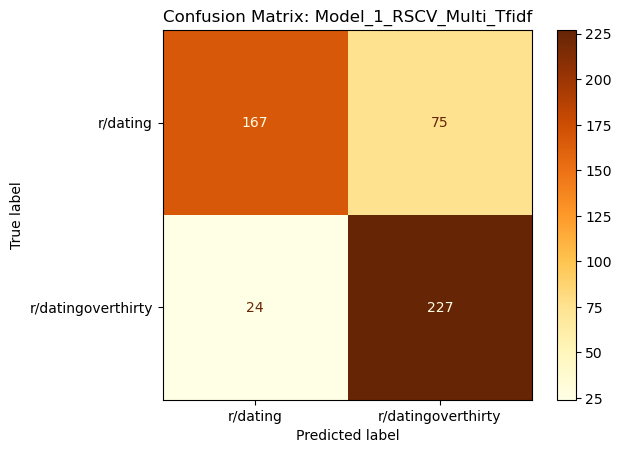

/var/folders/w7/4sqt0lt90t72lgqr2zq3p6l80000gn/T/ipykernel_33031/1195430848.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_capture = model_performance_capture.append(model_evaluation(rs1, 'Model_1_RSCV_Multi_Tfidf'))


In [522]:
model_performance_capture = model_performance_capture.append(model_evaluation(rs1, 'Model_1_RSCV_Multi_Tfidf'))

### 02 - RandomSearchCV over Multiple Estimators with CountVectorization

#### Pipeline and Parameters

In [523]:
pipe2 = Pipeline([
    ('cvec' , CountVectorizer()),
    ('cls' , Multi_Classifier())
])

cvec_params2 = {'cvec__max_df': [0.95, 0.9, 0.85],
         'cvec__ngram_range': [(1, 1), (1,2)],
         'cvec__preprocessor': [None, lemmatize_post],
         'cvec__stop_words': [None, 'english']}

logr_params2 = {'cls__estimator': [LogisticRegression()],
                'cls__estimator__C': np.linspace(0.00001, 1, 9)}

mnb_params2 = {'cls__estimator': [MultinomialNB()],}

ksvm_params2 = {'cls__estimator': [SVC()],
                 'cls__estimator__C': np.linspace(0.05, 2, 7),
                 'cls__estimator__degree': [2,3],
                 'cls__estimator__kernel': ['poly','rbf']}

params2 = [ # list of params... one for each estimator (order matters here). Cite: Tim Office Hours
            ## Logistic Regression
            cvec_params2 | logr_params2      

            ## Multinomial Naive Bayes
             ,cvec_params2| mnb_params2
    
            #Kernelized SVM
            ,cvec_params2 | ksvm_params2
           ]

In [524]:
rs2 = RandomizedSearchCV(estimator=pipe1,
                        param_distributions=params1,
                        cv = 5,
                        n_iter = 100
                       )

#### Model Fitting

In [444]:
# with open('./pickled_models/rs2_multi_cvec.pkl', 'wb') as f:
#     pickle.dump((rs2.best_estimator_, lemmatize_post), f)

In [441]:
# pickle.dump(rs2.best_estimator_, open('./pickled_models/rs2_multi_cvec.pkl', 'wb'))

In [525]:
%time
rs2.fit(X_train, y_train)
# pickle.dump(rs2, open('./pickled_models/rs2_multi_cvec.pkl', 'wb'))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words g

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('cls', Multi_Classifier())]),
                   n_iter=100,
                   param_distributions=[{'cls__estimator': [LogisticRegression()],
                                         'cls__estimator__C': array([0.9   , 1.0375, 1.175 , 1.3125, 1.45  , 1.5875, 1.725 , 1.8625,
       2.    ]),
                                         'tvec__max_df': [1.0, 0.9],
                                         'tvec__max_features': [None, 5000],
                                         'tvec__min_df': [1],
                                         'tvec__ngram_...
                                        {'cls__estimator': [SVC(C=1.675,
                                                                degree=2)],
                                         'cls__estimator__C': array([0.05 , 0.375, 0.7  , 1.025, 1.35 , 1.675, 2.   ]),
                                         'cls__estimator__degree': [2, 3],
                                         'cls__estimator__kernel': ['poly',
                                                                    'rbf'],
                                         'tvec__max_df': [1.0, 0.9],
                                         'tvec__max_features': [None, 5000],
                                         'tvec__min_df': [1],
                                         'tvec__ngram_range': [(1, 2)],
                                         'tvec__preprocessor': [<function lemmatize_post at 0x7fbf28e22710>],
                                         'tvec__stop_words': ['english']}])

#### Model Performance

Train-Test Accuracy Scores:
  Train: 1.0 
  Test: 0.80325
  Baseline: 0.50913
---

 Classification Report:
              precision    recall  f1-score   support

           0     0.8756    0.6983    0.7770       242
           1     0.7567    0.9044    0.8240       251

    accuracy                         0.8032       493
   macro avg     0.8162    0.8014    0.8005       493
weighted avg     0.8151    0.8032    0.8009       493


---
Best Parameters: 
{'tvec__stop_words': 'english', 'tvec__preprocessor': <function lemmatize_post at 0x7fbf28e22710>, 'tvec__ngram_range': (1, 2), 'tvec__min_df': 1, 'tvec__max_features': None, 'tvec__max_df': 1.0, 'cls__estimator__kernel': 'rbf', 'cls__estimator__degree': 2, 'cls__estimator__C': 1.675, 'cls__estimator': SVC(C=1.675, degree=2)}


<Figure size 800x500 with 0 Axes>

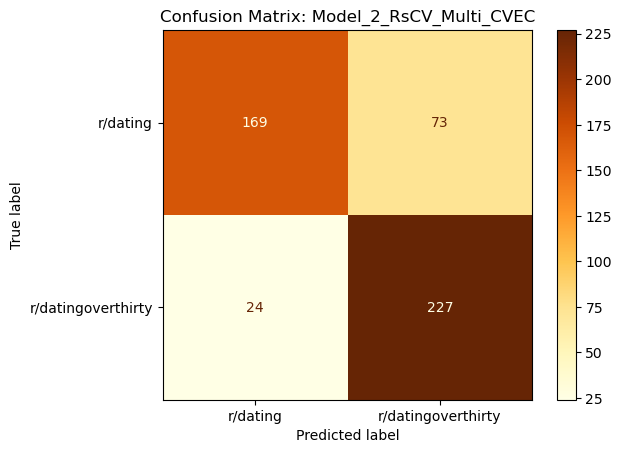

/var/folders/w7/4sqt0lt90t72lgqr2zq3p6l80000gn/T/ipykernel_33031/2230439169.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_capture = model_performance_capture.append(model_evaluation(rs2, 'Model_2_RsCV_Multi_CVEC'))


In [526]:
model_performance_capture = model_performance_capture.append(model_evaluation(rs2, 'Model_2_RsCV_Multi_CVEC'))

## Tree-Based Models

### 03 - Bagged Trees

#### Pipeline and Parameters

In [527]:
params3 = {
     'tvec__preprocessor': [None                            #Best Fit V1
                            # ,stem_post
                            ,lemmatize_post
                           ],
     'tvec__max_df': np.linspace(0.75, 0.95,6),               #0.9 on [1, 0.9] V1
     'tvec__max_features': [4000, 5000, 6000], #5000 on [None, 5000] V1
     'tvec__min_df': [1],
     'tvec__ngram_range': [(1, 1), (1, 2)],
     'tvec__stop_words': ['english'],                #english best in V1 [None, 'english']
     
    'bag__estimator__max_depth': np.arange(8,11,1),  #10 on V1
     'bag__estimator__min_samples_leaf': np.arange(1, 4, 1), # 1 in V1
     'bag__n_estimators': [200]
}
tree = DecisionTreeClassifier()

pipe3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bag', BaggingClassifier(tree))
])

rs3 = RandomizedSearchCV(estimator=pipe3, 
                         param_distributions=params3, 
                         cv = 5, 
                         n_iter = 100)

#### Model Fitting

In [528]:
rs3.fit(X_train, y_train)
# pickle.dump(rs3, open('./pickled_models/rs3_bagged_trees.pkl', 'wb'))

/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words g

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('bag',
                                              BaggingClassifier(estimator=DecisionTreeClassifier()))]),
                   n_iter=100,
                   param_distributions={'bag__estimator__max_depth': array([ 8,  9, 10]),
                                        'bag__estimator__min_samples_leaf': array([1, 2, 3]),
                                        'bag__n_estimators': [200],
                                        'tvec__max_df': array([0.75, 0.79, 0.83, 0.87, 0.91, 0.95]),
                                        'tvec__max_features': [4000, 5000,
                                                               6000],
                                        'tvec__min_df': [1],
                                        'tvec__ngram_range': [(1, 1), (1, 2)],
                                        'tvec__preprocessor': [None,
                                                               <function lemmatize_post at 0x7fbf28e23a30>],
                                        'tvec__stop_words': ['english']})

#### Model Performance

Train-Test Accuracy Scores:
  Train: 0.94993 
  Test: 0.76471
  Baseline: 0.50913
---

 Classification Report:
              precision    recall  f1-score   support

           0     0.7480    0.7851    0.7661       242
           1     0.7824    0.7450    0.7633       251

    accuracy                         0.7647       493
   macro avg     0.7652    0.7651    0.7647       493
weighted avg     0.7655    0.7647    0.7647       493


---
Best Parameters: 
{'tvec__stop_words': 'english', 'tvec__preprocessor': None, 'tvec__ngram_range': (1, 1), 'tvec__min_df': 1, 'tvec__max_features': 6000, 'tvec__max_df': 0.95, 'bag__n_estimators': 200, 'bag__estimator__min_samples_leaf': 1, 'bag__estimator__max_depth': 9}


<Figure size 800x500 with 0 Axes>

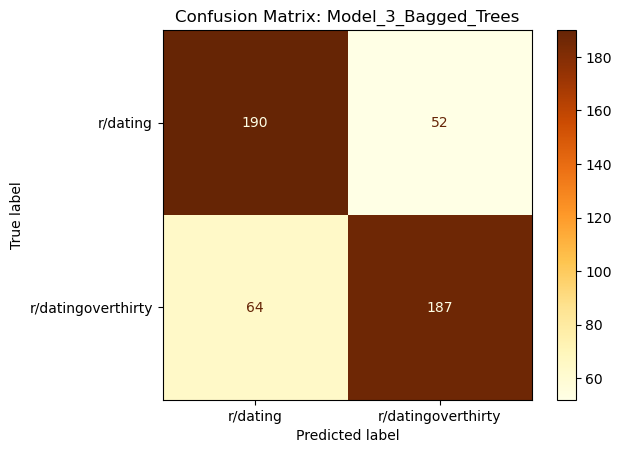

/var/folders/w7/4sqt0lt90t72lgqr2zq3p6l80000gn/T/ipykernel_33031/1974463261.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_capture = model_performance_capture.append(model_evaluation(rs3, 'Model_3_Bagged_Trees'))


In [529]:
model_performance_capture = model_performance_capture.append(model_evaluation(rs3, 'Model_3_Bagged_Trees'))

### 04 - RandomForest Classifier

#### Pipeline and Parameters

In [530]:
params4 = {
    'tvec__preprocessor': [None, lemmatize_post],
     'tvec__max_df': np.linspace(0.75, 0.95,6),              
     'tvec__max_features': [4000, 5000, 6000],
     'tvec__min_df': [1],
     'tvec__ngram_range': [(1, 1), (1, 2)],
     'tvec__stop_words': ['english'],       
    
     'rfc__max_depth': [10,20],
     'rfc__min_samples_split': [2,4,8],
     'rfc__n_estimators': [100],
     'rfc__random_state': [2187]
}

pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier()),
])

rs4 = RandomizedSearchCV(estimator=pipe4, 
                         param_distributions=params4, 
                         n_iter = 200)

#### Model Fitting

In [ ]:
rs4.fit(X_train, y_train)
# pickle.dump(rs4, open('./pickled_models/rs4_Random_Forest.pkl', 'wb'))

/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(
/Users/robertadams/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words g

#### Model Performance

In [ ]:
model_performance_capture = model_performance_capture.append(model_evaluation(rs4, 'Model_4_Random_Forrest'))

### 05 - Boosted Trees with AdaBoostClassifier

#### Pipeline and Parameters

In [ ]:
params5 = {
     'tvec__preprocessor': [None,lemmatize_post],
     'tvec__max_df': np.linspace(0.75, 0.95,6),              
     'tvec__max_features': [4000, 5000, 6000], 
     'tvec__min_df': [1],
     'tvec__ngram_range': [(1, 1), (1, 2)],
     'tvec__stop_words': ['english'],      
    
     'ada__estimator': [None], #DecisionTreeClassifier default
     'ada__learning_rate': [0.1, 1, 10],
     'ada__n_estimators': [10,20,30],
}

pipe5 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

rs5 = RandomizedSearchCV(estimator=pipe5, param_distributions=params5, cv = 5, n_iter = 100)

#### Model Fitting

In [ ]:
rs5.fit(X_train, y_train)
# pickle.dump(rs5, open('./pickled_models/rs5_AdaBoosted_Trees.pkl', 'wb'))

#### Model Performance

In [ ]:
model_performance_capture = model_performance_capture.append(model_evaluation(rs5, 'Model_5_AdaBoostClassifier'))

## Single Estimator Models for Ensembling

### 06 Kernelized SVM

In [ ]:
# class MultiVectorizer(TransformerMixin):
#     def __init__(self, vectorizer='CountVectorizer', **kwargs):  # CountVectorizer as Default
#         self.label = vectorizer
#         if vectorizer == 'TFIDF':
#             self.vectorizer = TfidfVectorizer(**kwargs)
#         elif vectorizer == 'CountVectorizer':
#             self.vectorizer = CountVectorizer(**kwargs)
    
#     def fit(self, X, y=None):
#         return self.vectorizer.fit(X, y)
    
#     def transform(self, X):
#         return self.vectorizer.transform(X)
    
#     def get_params(self, **kwargs):
#         return {**self.vectorizer.get_params(**kwargs), 'vectorizer':self.label}
    
#     def set_params(self, **params):
#         return self.vectorizer.set_params(**params)

In [ ]:
tvec6 = {
     'tvec__preprocessor': [None,lemmatize_post],
     'tvec__max_df': np.linspace(0.75, 0.95,6),              
     'tvec__max_features': [4000, 5000, 6000], 
     'tvec__min_df': [1],
     'tvec__ngram_range': [(1, 1), (1, 2)],
     'tvec__stop_words': ['english'],
}

ksvm_params6 = {
    'ksvm__C': np.linspace(0.05, 2, 7),
    'ksvm__degree': [2, 3],
    'ksvm__kernel': ['poly', 'rbf']
}

params6 = {
    **tvec6, **ksvm_params6
}

pipe6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ksvm', SVC())
])
pipe6.get_params()

In [ ]:
rs6 = RandomizedSearchCV(estimator=pipe6,
                        param_distributions=params6,
                        cv = 5,
                        n_iter = 1
                       )

#### Model Fitting

In [ ]:
%time
rs6.fit(X_train, y_train)
# pickle.dump(rs6, open('./pickled_models/rs6_SVM_Multi_Vectorizer.pkl', 'wb'))

#### Model Performance

In [ ]:
model_performance_capture = model_performance_capture.append(model_evaluation(rs6, 'Model_6_SVM_TFIDF'))

## Ensembling

In [ ]:
#cite: mors: https://stackoverflow.com/questions/42920148/using-sklearn-voting-ensemble-with-partial-fit
# VotingClassifier Ensembling without model refit.
classifier_list = [rs1, rs2, rs3, rs4, rs5, rs6]

classifier_estimators = VotingClassifier(estimators = [('Model_1_RSCV_Multi_Tfidf' ,rs1),
                                                       ('Model_2_RsCV_Multi_CVEC', rs2),
                                                       ('Model_3_Bagged_Trees', rs3),
                                                      ('Model_4_Random_Forrest', rs4),
                                                      ('Model_5_AdaBoostClassifier', rs5),
                                                      ('Model_6_SVM_TFIDF', rs6)], voting='soft')

classifier_estimators.estimators_ = classifier_list
classifier_estimators.le_ = LabelEncoder().fit(y)
classifier_estimators.classes_ = classifier_estimators.le_.classes_

# Now it will work without calling fit
classifier_estimators.predict(X)

#### Model Performance

In [ ]:
model_performance_capture = model_performance_capture.append(model_evaluation(classifier_estimators, 'Model_7_VotingClassifier'))

In [ ]:
model_performance_capture